### In this script, DBN is run on the all the sessions
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [11]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [12]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    if not do_bestsession:
        dates_list = [
                      "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                      "20221011","20221013","20221014","20221015","20221017","20230215",     
                      "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                      "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",
                      "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                      "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220",
                      "20221221","20230208","20230209","20230213","20230214","20230111","20230112","20230201",

                     ]
        session_start_times = [ 
                                 6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                                 2.80, 27.80, 272.50, 27.90, 27.00,  33.00,
                                28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                                15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 
                                75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                                 0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  
                                 0.00,  0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      # "20220912",
                      "20220915","20220920","20221010","20230208",
                      "20221011","20221013","20221015","20221017",
                      "20221022","20221026","20221028","20221030","20230209",
                      "20221125","20221128","20221129","20230214","20230215",                  
                      "20221205","20221206","20221209","20221214","20230112",
                      "20230117","20230118","20230124",
                      # "20230126",
                     ]
        session_start_times = [ 
                                # 18.10, 
                                 0.00, 33.03,  6.50,  0.00, 
                                 2.80, 27.80, 27.90, 27.00,  
                                51.90, 21.00, 30.80, 17.50,  0.00,                    
                                26.40, 22.50, 28.50,  0.00, 33.00,                     
                                 0.00,  0.00, 21.70, 17.00, 14.20, 
                                 0.00,  0.00,  0.00, 
                                 # 0.00,  
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 1:
    if not do_bestsession:
        dates_list = [
                      "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                      "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                      "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                      "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                      "20230321","20230322","20230324","20230327","20230328",
                      "20230330","20230331","20230403","20230404","20230405","20230406","20230407",
                      
                   ]
        session_start_times = [ 
                                 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                                 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                                 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                                 8.00,8.00,4.00,123.00,14.00,8.80,
                                 7.00,7.50,5.50,11.00,9.00,
                                 17.00,4.50,9.30,25.50,20.40,21.30,24.80,
                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                      "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                      "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                      "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  9.50,   1.00, 38.00,  4.20,  3.80,
                                  9.00,   7.50,  8.50, 14.50,  7.80,
                                  8.00,   7.50,  8.00,  8.00,  4.00,
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                                  4.50,   9.30, 25.50, 20.40, 21.30,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                      "20230303","20230307","20230314","20230315","20230316","20230317"         
                   ]
        session_start_times = [ 
                                 0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                                34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      #"20230213",
                      "20230214","20230216",
                      "20230228","20230302","20230303","20230307",          
                      "20230314","20230315","20230316","20230317",
                      "20230301","20230320","20230321","20230322",
                      "20230323","20230412","20230413","20230517","20230614","20230615",
                      "20230522_ws","20230524","20230605_1","20230606","20230607"
                   ]
        session_start_times = [ 
                                # 0.00, 
                                 0.00, 48.00, 
                                23.00, 28.50, 34.00, 25.50, 
                                25.50, 31.50, 28.00, 30.50,
                                33.50, 22.20, 50.00,  0.00, 
                                33.00, 18.20, 22.80, 31.00, 24.00, 21.00,
                                 0.00,  0.00,  0.00,  0.00,  0.00,
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
# dannon kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013",
                      # these days haven't analyzed in the allsession condition
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0, # 0, 0, 0, 
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230718","20230720","20230914","20230726","20230727","20230809",
                      "20230810","20230811","20230814","20230816","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013","20231020","20231024","20231025",
                   ]
        session_start_times = [ 
                                    0,    0,    0, 32.2, 27.2, 37.5,
                                 21.0, 21.5, 19.8, 32.0,    0,    0,   0, 
                                    0,    0,    0,    0,    0,    0,
                                    0,    0,    0,    0, 
                              ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"

# Koala Vermelho
if 0:
    if not do_bestsession:
        dates_list = [
                      "20231221",  "20231222","20231226","20231227",  "20231229","20231230",
                      "20231231",  "20240102","20240104","20240104-2","20240105","20240108",
                      "20240109",  "20240115","20240116","20240117",  "20240118","20240119",
                      "20240122",  "20240123","20240124","20240125",  "20240126","20240129",
                      "20240130",  "20240131","20240201","20240202",  "20240205","20240206_1",
                      "20240206_2","20240207","20240208","20240209",  "20240212","20240213",
                      "20240214",  "20240215","20240216","20240219",  "20240220","20240222", 
                      "20240223",  "20240226",
                     ]
        session_start_times = [ 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      "20231222","20231226","20231227",  "20231229","20231230",
                      "20231231","20240102","20240104-2","20240105","20240108",
                      "20240109","20240115","20240116",  "20240117","20240118","20240119",
                      "20240207","20240208","20240209",  "20240212","20240213",
                      "20240214","20240215","20240216",  "20240220","20240222","20240223",
                     ]
        session_start_times = [ 
                                21.5,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  12.2,  0.00,  18.8,  31.2,  
                                32.5,  0.00,  50.0,  0.00,  37.5,  29.5,
                                58.5,  72.0,  0.00,  71.5,  70.5,
                                86.8,  94.0,  65.0,  68.8,  43.8,  13.2,
                              ] # in second
    
    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    
#    
# dates_list = ["20221128"]
# session_start_times = [1.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

In [13]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
        try: 
            bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
            video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
        except:
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
        pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
  

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
            
                
        # # plot behavioral events
        if np.isin(animal1,animal1_fixedorder):
                plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
        else:
                plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
        #
        # save behavioral events plot
        if 0:
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")

        #
        owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
        owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
        mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
        mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]

        # analyze the events interval, especially for the pull to other and other to pull interval
        # could be used for define time bin for DBN
        if 1:
            _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                         oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #
            pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
            bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                            'pull_other_pooled': pull_other_pool_itv}
        
        # plot the tracking demo video
        if 1: 
            tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                              lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                              animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                              animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                              video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        

    # save data
    if 1:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

all data from all dates are loaded


#### redefine the tasktype and cooperation threshold to merge them together

In [14]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision

tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting

### plot behavioral events interval to get a sense about time bin
#### only focus on pull_to_other_bhv_interval and other_bhv_to_pull_interval

[1.25413534 3.93133641 2.72666667 1.04       1.89896907 2.4366548
 1.66333333 1.35128205 1.725      0.77234043 1.07867647 1.67349398
 0.28072289 1.3358209  0.46603774 0.45117371 0.2602649  0.39724138
 0.29331683 0.42712766 0.22762148 1.22994505 2.1195122  1.46363636
 1.78122066 2.1475     1.19878788]
1.230512249443207


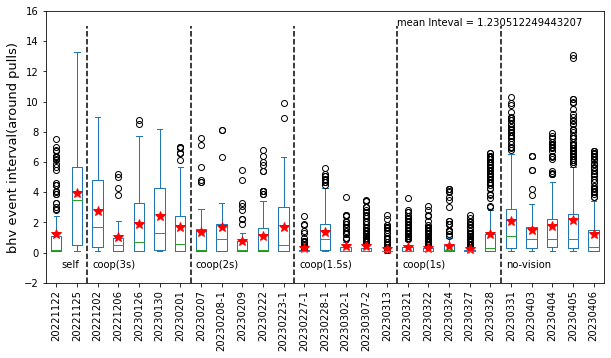

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pull_other_intv_forplots = {}
pull_other_intv_mean = np.zeros((1,ndates_sorted))[0]
pull_other_intv_ii = []
for ii in np.arange(0,ndates_sorted,1):
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[dates_list_sorted[ii]]['pull_other_pooled'])
    # remove the interval that is too large
    pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
    pull_other_intv_forplots[ii] = pull_other_intv_ii
    pull_other_intv_mean[ii] = np.nanmean(pull_other_intv_ii)
    
    
#
pull_other_intv_forplots = pd.DataFrame(pull_other_intv_forplots)

#
# plot
pull_other_intv_forplots.plot(kind = 'box',ax=ax1, positions=np.arange(0,ndates_sorted,1))
# plt.boxplot(pull_other_intv_forplots)
plt.plot(np.arange(0,ndates_sorted,1),pull_other_intv_mean,'r*',markersize=10)
#
ax1.set_ylabel("bhv event interval(around pulls)",fontsize=13)
ax1.set_ylim([-2,16])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-2,15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-1,tasktypes[itaskswitch],fontsize=10)
ax1.text(taskswitch-5,15,'mean Inteval = '+str(np.nanmean(pull_other_intv_forplots)),fontsize=10)

print(pull_other_intv_mean)
print(np.nanmean(pull_other_intv_forplots))

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"bhvInterval_hist_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')

### plot some other basis behavioral measures
#### successful rate

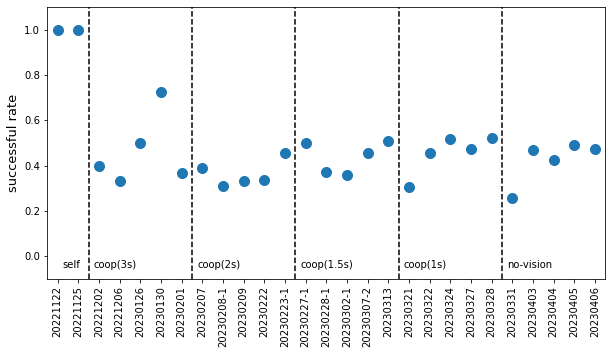

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]


ax1.plot(np.arange(0,ndates_sorted,1),succ_rate_all_dates[sorting_df.index],'o',markersize=10)
#
ax1.set_ylabel("successful rate",fontsize=13)
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([-0.5,ndates_sorted-0.5])
#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"successfulrate_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')


#### animal pull numbers

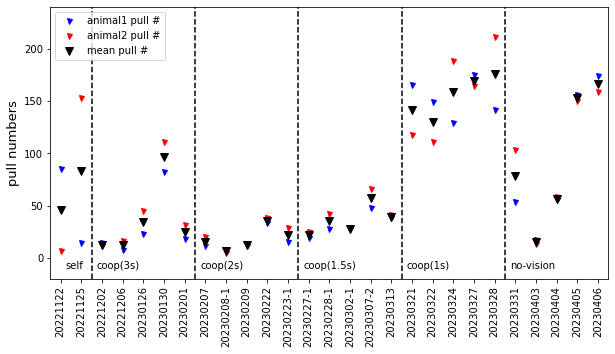

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
ax1.plot(np.arange(0,ndates_sorted,1),pull1_num_all_dates[sorting_df.index],'bv',markersize=5,label='animal1 pull #')
ax1.plot(np.arange(0,ndates_sorted,1),pull2_num_all_dates[sorting_df.index],'rv',markersize=5,label='animal2 pull #')
ax1.plot(np.arange(0,ndates_sorted,1),pullmean_num_all_dates[sorting_df.index],'kv',markersize=8,label='mean pull #')
ax1.legend()


#
ax1.set_ylabel("pull numbers",fontsize=13)
ax1.set_ylim([-20,240])
ax1.set_xlim([-0.5,ndates_sorted-0.5])

#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-20,240],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-10,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"pullnumbers_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')


#### gaze number

In [18]:

gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

print(np.nanmax(gaze1_num_all_dates))
print(np.nanmax(gaze2_num_all_dates))

2153.0
1873.0


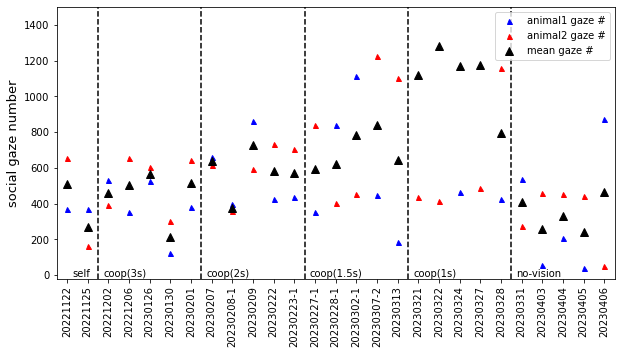

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]



ax1.plot(np.arange(0,ndates_sorted,1),gaze1_num_all_dates[sorting_df.index],'b^',markersize=5,label='animal1 gaze #')
ax1.plot(np.arange(0,ndates_sorted,1),gaze2_num_all_dates[sorting_df.index],'r^',markersize=5,label='animal2 gaze #')
ax1.plot(np.arange(0,ndates_sorted,1),gazemean_num_all_dates[sorting_df.index],'k^',markersize=8,label='mean gaze #')
ax1.legend()


#
ax1.set_ylabel("social gaze number",fontsize=13)
ax1.set_ylim([-20,1500])
ax1.set_xlim([-0.5,ndates_sorted-0.5])

#
plt.xticks(np.arange(0,ndates_sorted,1),dates_list_sorted, rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-20,1500],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-10,tasktypes[itaskswitch],fontsize=10)
    
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"gazenumbers_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.jpg')


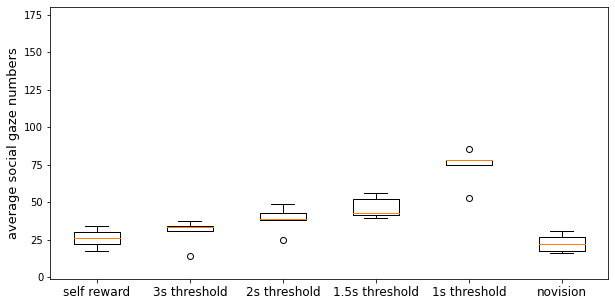

In [20]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/30
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)/30

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']

gaze_numbers_groups = [np.transpose(gaze_numbers[np.transpose(coopthres_forsort==100)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==3)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==2)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==1.5)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==1)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_forsort==-1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
ax1.set_ylim([-30/30,5400/30])
ax1.set_ylabel("average social gaze numbers",fontsize=13)

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"averaged_gazenumbers_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')


### prepare the input data for DBN

In [21]:
# define DBN related summarizing variables
DBN_input_data_alltypes = dict.fromkeys(dates_list, [])

doBhvitv_timebin = 0 # 1: if use the mean bhv event interval for time bin

prepare_input_data = 0

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]

mergetempRos = 0

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
    
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # load behavioral results
        try:
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
        except:    
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
            
        # get animal info
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()
        
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]
            
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1

        # load behavioral event results
        print('load social gaze with '+cameraID+' only of '+date_tgt)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
            output_look_ornot = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
            output_allvectors = pickle.load(f)
        with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
            output_allangles = pickle.load(f)  
        #
        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        # change the unit to second
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']   


        if mergetempRos:
            temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
            # use bhv event to decide temporal resolution
            #
            #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)
        #
        if doBhvitv_timebin:
            pull_other_intv_ii = pd.Series(bhv_intv_all_dates[date_tgt]['pull_other_pooled'])
            # remove the interval that is too large
            pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
            # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
            temp_resolus = [np.nanmean(pull_other_intv_ii)]          
        #
        ntemp_reses = np.shape(temp_resolus)[0]           

        
        # try different temporal resolutions
        for temp_resolu in temp_resolus:
            bhv_df = []

            if np.isin(animal1,animal1_fixedorder):
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     

            if len(bhv_df)==0:
                bhv_df = bhv_df_itr
            else:
                bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                bhv_df = bhv_df.reset_index(drop=True)        

            DBN_input_data_alltypes[date_tgt] = bhv_df
            
    # save data
    if 1:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                    pickle.dump(DBN_input_data_alltypes, f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                    pickle.dump(DBN_input_data_alltypes, f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'wb') as f:
                pickle.dump(DBN_input_data_alltypes, f)     

In [22]:
# DBN_input_data_alltypes['20240223']

#### plot the gaze distribution around pulls, analysis is based on the DBN_input_data all session format
#### similar plot was in "3LagDBN_and_SuccAndFailedPull_singlecam_wholebodylabels_allsessions_basicEvents" looking at the difference between successful and failed pulls
#### pool across all animals, compared self reward, 3s to 1s cooperation and no vision

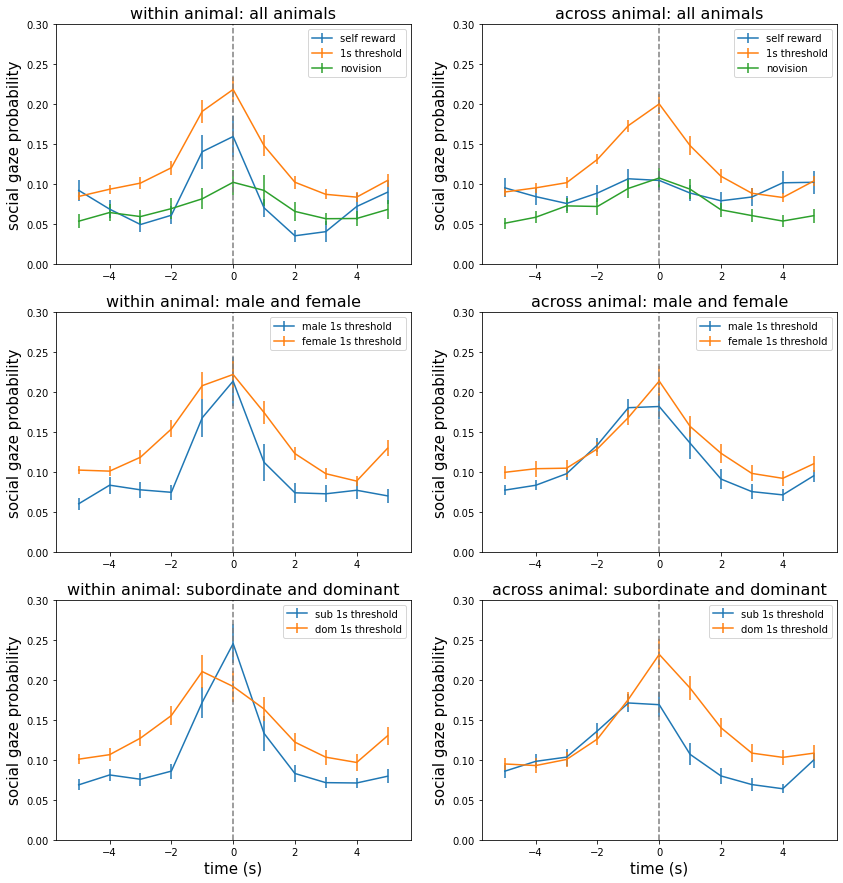

In [23]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga_1','kanga_2','vermelho']
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1
dist_twin_range = 5

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']
coopthres_IDs = [100, 3, 2, 1.5, 1, -1]
ngrouptypes = np.shape(grouptypes)[0]

# initiate the final data set
SameAnimal_gazeDist_mean_forEachAni = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_mean_forEachAni = dict.fromkeys(grouptypes,[])
# shuffle both the pull and gaze time stamp
SameAnimal_gazeDist_shuffle_forEachAni = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_shuffle_forEachAni = dict.fromkeys(grouptypes,[])
#
SameAnimal_gazeDist_mean_all = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_mean_all = dict.fromkeys(grouptypes,[])
# shuffle both the pull and gaze time stamp
SameAnimal_gazeDist_shuffle_all = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_shuffle_all = dict.fromkeys(grouptypes,[])
#
malenames = ['eddie','dodson','dannon','vermelho']
femalenames = ['sparkle','scorch','kanga_1','kanga_2','ginger','koala']
SameAnimal_gazeDist_mean_male = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_mean_male = dict.fromkeys(grouptypes,[])
SameAnimal_gazeDist_mean_female = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_mean_female = dict.fromkeys(grouptypes,[])
#
subnames = ['eddie','dodson','dannon','ginger','koala']
domnames = ['sparkle','scorch','kanga_1','kanga_2','vermelho']
SameAnimal_gazeDist_mean_sub = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_mean_sub = dict.fromkeys(grouptypes,[])
SameAnimal_gazeDist_mean_dom = dict.fromkeys(grouptypes,[])
AcroAnimal_gazeDist_mean_dom = dict.fromkeys(grouptypes,[])




#
for igrouptype in np.arange(0,ngrouptypes,1):
    
    grouptype = grouptypes[igrouptype]
    coopthres_ID = coopthres_IDs[igrouptype]
    
    SameAnimal_gazeDist_mean_forEachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])
    AcroAnimal_gazeDist_mean_forEachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])
    SameAnimal_gazeDist_shuffle_forEachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])
    AcroAnimal_gazeDist_shuffle_forEachAni[grouptype] = dict.fromkeys(animal1_fixedorders+animal2_fixedorders,[])   
    
    for ianimalpair in np.arange(0,nanimalpairs,1):
        animal1_fixedorder = animal1_fixedorders[ianimalpair]
        animal2_fixedorder = animal2_fixedorders[ianimalpair]

        if (animal2_fixedorder == 'kanga_1') | (animal2_fixedorder == 'kanga_2'):
            animal2_filename = 'kanga'
        else:
            animal2_filename = animal2_fixedorder
            
        # load the basic behavioral measures
        # load saved data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_filename+'/'
        #
        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_filename+'.pkl', 'rb') as f:
            tasktypes_all_dates = pickle.load(f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_filename+'.pkl', 'rb') as f:
            coopthres_all_dates = pickle.load(f)

        #     
        # load the DBN related analysis
        # load data
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_filename+'/'
        #
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_filename+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_filename+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

        #
        # re-organize the target dates
        # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
        tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
        coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
        coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting


        #
        # sort the data based on task type and dates
        dates_list = list(DBN_input_data_alltypes.keys())
        sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
        sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
        #
        # only select the targeted dates
        sorting_tgt_df = sorting_df[(sorting_df['coopthres']==coopthres_ID)]
        dates_list_tgt = sorting_tgt_df['dates']
        dates_list_tgt = np.array(dates_list_tgt)
        #
        ndates_tgt = np.shape(dates_list_tgt)[0]

        #
        # initiate the final data set
        SameAnimal_gazeDist_mean_forEachAni[grouptype][animal1_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        SameAnimal_gazeDist_mean_forEachAni[grouptype][animal2_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        AcroAnimal_gazeDist_mean_forEachAni[grouptype][animal1_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        AcroAnimal_gazeDist_mean_forEachAni[grouptype][animal2_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        #
        SameAnimal_gazeDist_shuffle_forEachAni[grouptype][animal1_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        SameAnimal_gazeDist_shuffle_forEachAni[grouptype][animal2_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][animal1_fixedorder] = dict.fromkeys(dates_list_tgt,[])
        AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][animal2_fixedorder] = dict.fromkeys(dates_list_tgt,[])

        # 
        for idate in np.arange(0,ndates_tgt,1):
            idate_name = dates_list_tgt[idate]

            DBN_input_data_idate = DBN_input_data_alltypes[idate_name]
            
            # pull1_t0 and gaze1_t0
            xxx1 = (np.array(DBN_input_data_idate['pull1_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
            xxx1_shuffle = xxx1.copy()
            np.random.shuffle(xxx1_shuffle)
            xxx2_shuffle = xxx2.copy()
            np.random.shuffle(xxx2_shuffle)
            # pad the two sides
            xxx1 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1,np.zeros((1,dist_twin_range))[0]])
            xxx2 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2,np.zeros((1,dist_twin_range))[0]])
            xxx1_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1_shuffle,np.zeros((1,dist_twin_range))[0]])
            xxx2_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2_shuffle,np.zeros((1,dist_twin_range))[0]])
            # 
            npulls = int(np.nansum(xxx1))
            pullIDs = np.where(xxx1 == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            SameAnimal_gazeDist_mean_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                SameAnimal_gazeDist_mean_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
            # shuffle
            npulls = int(np.nansum(xxx1_shuffle))
            pullIDs = np.where(xxx1_shuffle == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2_shuffle[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            SameAnimal_gazeDist_shuffle_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                SameAnimal_gazeDist_shuffle_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                
            # pull2_t0 and gaze2_t0
            xxx1 = (np.array(DBN_input_data_idate['pull2_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
            xxx1_shuffle = xxx1.copy()
            np.random.shuffle(xxx1_shuffle)
            xxx2_shuffle = xxx2.copy()
            np.random.shuffle(xxx2_shuffle)
            # pad the two sides
            xxx1 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1,np.zeros((1,dist_twin_range))[0]])
            xxx2 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2,np.zeros((1,dist_twin_range))[0]])
            xxx1_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1_shuffle,np.zeros((1,dist_twin_range))[0]])
            xxx2_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2_shuffle,np.zeros((1,dist_twin_range))[0]])
            # 
            npulls = int(np.nansum(xxx1))
            pullIDs = np.where(xxx1 == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            SameAnimal_gazeDist_mean_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                SameAnimal_gazeDist_mean_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan 
            # shuffle
            npulls = int(np.nansum(xxx1_shuffle))
            pullIDs = np.where(xxx1_shuffle == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2_shuffle[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            SameAnimal_gazeDist_shuffle_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                SameAnimal_gazeDist_shuffle_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan 
                
            # pull1_t0 and gaze2_t0
            xxx1 = (np.array(DBN_input_data_idate['pull1_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
            xxx1_shuffle = xxx1.copy()
            np.random.shuffle(xxx1_shuffle)
            xxx2_shuffle = xxx2.copy()
            np.random.shuffle(xxx2_shuffle)
            # pad the two sides
            xxx1 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1,np.zeros((1,dist_twin_range))[0]])
            xxx2 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2,np.zeros((1,dist_twin_range))[0]])
            xxx1_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1_shuffle,np.zeros((1,dist_twin_range))[0]])
            xxx2_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2_shuffle,np.zeros((1,dist_twin_range))[0]])
            # 
            npulls = int(np.nansum(xxx1))
            pullIDs = np.where(xxx1 == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            AcroAnimal_gazeDist_mean_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                AcroAnimal_gazeDist_mean_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan 
            # shuffle
            npulls = int(np.nansum(xxx1_shuffle))
            pullIDs = np.where(xxx1_shuffle == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2_shuffle[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][animal1_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan 
    
            # pull2_t0 and gaze1_t0
            xxx1 = (np.array(DBN_input_data_idate['pull2_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
            xxx1_shuffle = xxx1.copy()
            np.random.shuffle(xxx1_shuffle)
            xxx2_shuffle = xxx2.copy()
            np.random.shuffle(xxx2_shuffle)
            # pad the two sides
            xxx1 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1,np.zeros((1,dist_twin_range))[0]])
            xxx2 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2,np.zeros((1,dist_twin_range))[0]])
            xxx1_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1_shuffle,np.zeros((1,dist_twin_range))[0]])
            xxx2_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2_shuffle,np.zeros((1,dist_twin_range))[0]])
            # 
            npulls = int(np.nansum(xxx1))
            pullIDs = np.where(xxx1 == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            AcroAnimal_gazeDist_mean_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                AcroAnimal_gazeDist_mean_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan 
            # shuffle
            npulls = int(np.nansum(xxx1_shuffle))
            pullIDs = np.where(xxx1_shuffle == 1)[0]
            gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
            #
            for ipull in np.arange(0,npulls,1):
                pullID = pullIDs[ipull]
                gazenum_dist_temp[ipull,:] = xxx2_shuffle[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
            AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.nanmean(gazenum_dist_temp,axis=0)/(np.sum(xxx2)/np.sum(xxx1))
            if npulls == 0:
                AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][animal2_fixedorder][idate_name]=np.ones((1,2*dist_twin_range+1))[0]*np.nan 

    
    # combine across all animals
    df = pd.DataFrame([SameAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in animal1_fixedorders+animal2_fixedorders])
    SameAnimal_gazeDist_mean_all[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([AcroAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in animal1_fixedorders+animal2_fixedorders])
    AcroAnimal_gazeDist_mean_all[grouptype] = np.vstack(df.stack().values)
    
    # combine across al animals for shuffle
    df = pd.DataFrame([SameAnimal_gazeDist_shuffle_forEachAni[grouptype][name] for name in animal1_fixedorders+animal2_fixedorders])
    SameAnimal_gazeDist_shuffle_all[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([AcroAnimal_gazeDist_shuffle_forEachAni[grouptype][name] for name in animal1_fixedorders+animal2_fixedorders])
    AcroAnimal_gazeDist_shuffle_all[grouptype] = np.vstack(df.stack().values)
    
    # combine across male and female
    df = pd.DataFrame([SameAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in malenames])
    SameAnimal_gazeDist_mean_male[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([AcroAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in malenames])
    AcroAnimal_gazeDist_mean_male[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([SameAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in femalenames])
    SameAnimal_gazeDist_mean_female[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([AcroAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in femalenames])
    AcroAnimal_gazeDist_mean_female[grouptype] = np.vstack(df.stack().values)
    
    # combine across sub and dom
    df = pd.DataFrame([SameAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in subnames])
    SameAnimal_gazeDist_mean_sub[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([AcroAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in subnames])
    AcroAnimal_gazeDist_mean_sub[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([SameAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in domnames])
    SameAnimal_gazeDist_mean_dom[grouptype] = np.vstack(df.stack().values)
    df = pd.DataFrame([AcroAnimal_gazeDist_mean_forEachAni[grouptype][name] for name in domnames])
    AcroAnimal_gazeDist_mean_dom[grouptype] = np.vstack(df.stack().values)
    
    
#
if 1:
    
    xxx = np.arange(-dist_twin_range,dist_twin_range+1,1)
    
    fig, axs = plt.subplots(3, 2)
    fig.set_figheight(5*3)
    fig.set_figwidth(7*2)   
    
    # plot the summarizing figure
    # plot the within animal and across animal distribution
    
    for iplottype in np.arange(0,2,1):
        # 
        # plot, all animals
        conds_forplot = ['self reward','1s threshold','novision']
        # conds_forplot = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold','novision']
        gazeDist_average_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_std_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_average_shf_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_std_shf_forplot = dict.fromkeys(conds_forplot,[])
        for cond_forplot in conds_forplot:
            if iplottype == 0:
                gazeDist_average_forplot[cond_forplot] = np.nanmean(SameAnimal_gazeDist_mean_all[cond_forplot],axis=0)
                gazeDist_std_forplot[cond_forplot] = np.nanstd(SameAnimal_gazeDist_mean_all[cond_forplot],axis=0)/np.sqrt(np.shape(SameAnimal_gazeDist_mean_all[cond_forplot])[0])
                #
                gazeDist_average_shf_forplot[cond_forplot] = np.nanmean(SameAnimal_gazeDist_shuffle_all[cond_forplot],axis=0)
                gazeDist_std_shf_forplot[cond_forplot] = np.nanstd(SameAnimal_gazeDist_shuffle_all[cond_forplot],axis=0)/np.sqrt(np.shape(SameAnimal_gazeDist_shuffle_all[cond_forplot])[0])
            elif iplottype == 1:
                gazeDist_average_forplot[cond_forplot] = np.nanmean(AcroAnimal_gazeDist_mean_all[cond_forplot],axis=0)
                gazeDist_std_forplot[cond_forplot] = np.nanstd(AcroAnimal_gazeDist_mean_all[cond_forplot],axis=0)/np.sqrt(np.shape(AcroAnimal_gazeDist_mean_all[cond_forplot])[0])
                #
                gazeDist_average_shf_forplot[cond_forplot] = np.nanmean(AcroAnimal_gazeDist_shuffle_all[cond_forplot],axis=0)
                gazeDist_std_shf_forplot[cond_forplot] = np.nanstd(AcroAnimal_gazeDist_shuffle_all[cond_forplot],axis=0)/np.sqrt(np.shape(AcroAnimal_gazeDist_shuffle_all[cond_forplot])[0])
            #
            axs[0,iplottype].errorbar(xxx,gazeDist_average_forplot[cond_forplot],
                            gazeDist_std_forplot[cond_forplot],label=cond_forplot)
            # axs[0,iplottype].errorbar(xxx,gazeDist_average_shf_forplot[cond_forplot],
            #                 gazeDist_std_shf_forplot[cond_forplot],label="shuffled "+cond_forplot)
        axs[0,iplottype].plot([0,0],[0,1],'--',color='0.5')
        axs[0,iplottype].set_xlim(-dist_twin_range-0.75,dist_twin_range+0.75)
        axs[0,iplottype].set_ylim(0,0.3)
        # axs[0,iplottype].set_xlabel('time (s)',fontsize=15)
        axs[0,iplottype].set_ylabel('social gaze probability',fontsize=15)
        axs[0,iplottype].legend()   
        if iplottype == 0:
            axs[0,iplottype].set_title('within animal: all animals',fontsize=16)   
        elif iplottype == 1:
            axs[0,iplottype].set_title('across animal: all animals',fontsize=16)

        # plot, male and female
        conds_forplot = ['1s threshold']
        gazeDist_average_male_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_std_male_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_average_female_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_std_female_forplot = dict.fromkeys(conds_forplot,[])
        for cond_forplot in conds_forplot:
            if iplottype == 0:
                gazeDist_average_male_forplot[cond_forplot] = np.nanmean(SameAnimal_gazeDist_mean_male[cond_forplot],axis=0)
                gazeDist_std_male_forplot[cond_forplot] = np.nanstd(SameAnimal_gazeDist_mean_male[cond_forplot],axis=0)/np.sqrt(np.shape(SameAnimal_gazeDist_mean_male[cond_forplot])[0])
                #
                gazeDist_average_female_forplot[cond_forplot] = np.nanmean(SameAnimal_gazeDist_mean_female[cond_forplot],axis=0)
                gazeDist_std_female_forplot[cond_forplot] = np.nanstd(SameAnimal_gazeDist_mean_female[cond_forplot],axis=0)/np.sqrt(np.shape(SameAnimal_gazeDist_mean_female[cond_forplot])[0])
            elif iplottype == 1:
                gazeDist_average_male_forplot[cond_forplot] = np.nanmean(AcroAnimal_gazeDist_mean_male[cond_forplot],axis=0)
                gazeDist_std_male_forplot[cond_forplot] = np.nanstd(AcroAnimal_gazeDist_mean_male[cond_forplot],axis=0)/np.sqrt(np.shape(AcroAnimal_gazeDist_mean_male[cond_forplot])[0])
                #
                gazeDist_average_female_forplot[cond_forplot] = np.nanmean(AcroAnimal_gazeDist_mean_female[cond_forplot],axis=0)
                gazeDist_std_female_forplot[cond_forplot] = np.nanstd(AcroAnimal_gazeDist_mean_female[cond_forplot],axis=0)/np.sqrt(np.shape(AcroAnimal_gazeDist_mean_female[cond_forplot])[0])
            #
            axs[1,iplottype].errorbar(xxx,gazeDist_average_male_forplot[cond_forplot],
                            gazeDist_std_male_forplot[cond_forplot],label='male '+cond_forplot)
            axs[1,iplottype].errorbar(xxx,gazeDist_average_female_forplot[cond_forplot],
                            gazeDist_std_female_forplot[cond_forplot],label='female '+cond_forplot)
        axs[1,iplottype].plot([0,0],[0,1],'--',color='0.5')
        axs[1,iplottype].set_xlim(-dist_twin_range-0.75,dist_twin_range+0.75)
        axs[1,iplottype].set_ylim(0,0.3)
        # axs[1,iplottype].set_xlabel('time (s)',fontsize=15)
        axs[1,iplottype].set_ylabel('social gaze probability',fontsize=15)
        axs[1,iplottype].legend()   
        if iplottype == 0:
            axs[1,iplottype].set_title('within animal: male and female',fontsize=16) 
        elif iplottype == 1:
            axs[1,iplottype].set_title('across animal: male and female',fontsize=16) 

        # plot, sub and dom
        conds_forplot = ['1s threshold']
        gazeDist_average_dom_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_std_dom_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_average_sub_forplot = dict.fromkeys(conds_forplot,[])
        gazeDist_std_sub_forplot = dict.fromkeys(conds_forplot,[])
        for cond_forplot in conds_forplot:
            if iplottype == 0:
                gazeDist_average_sub_forplot[cond_forplot] = np.nanmean(SameAnimal_gazeDist_mean_sub[cond_forplot],axis=0)
                gazeDist_std_sub_forplot[cond_forplot] = np.nanstd(SameAnimal_gazeDist_mean_sub[cond_forplot],axis=0)/np.sqrt(np.shape(SameAnimal_gazeDist_mean_sub[cond_forplot])[0]) 
                #
                gazeDist_average_dom_forplot[cond_forplot] = np.nanmean(SameAnimal_gazeDist_mean_dom[cond_forplot],axis=0)
                gazeDist_std_dom_forplot[cond_forplot] = np.nanstd(SameAnimal_gazeDist_mean_dom[cond_forplot],axis=0)/np.sqrt(np.shape(SameAnimal_gazeDist_mean_dom[cond_forplot])[0])
            elif iplottype == 1:
                gazeDist_average_sub_forplot[cond_forplot] = np.nanmean(AcroAnimal_gazeDist_mean_sub[cond_forplot],axis=0)
                gazeDist_std_sub_forplot[cond_forplot] = np.nanstd(AcroAnimal_gazeDist_mean_sub[cond_forplot],axis=0)/np.sqrt(np.shape(AcroAnimal_gazeDist_mean_sub[cond_forplot])[0]) 
                #
                gazeDist_average_dom_forplot[cond_forplot] = np.nanmean(AcroAnimal_gazeDist_mean_dom[cond_forplot],axis=0)
                gazeDist_std_dom_forplot[cond_forplot] = np.nanstd(AcroAnimal_gazeDist_mean_dom[cond_forplot],axis=0)/np.sqrt(np.shape(AcroAnimal_gazeDist_mean_dom[cond_forplot])[0])
            #
            axs[2,iplottype].errorbar(xxx,gazeDist_average_sub_forplot[cond_forplot],
                            gazeDist_std_sub_forplot[cond_forplot],label='sub '+cond_forplot)
            axs[2,iplottype].errorbar(xxx,gazeDist_average_dom_forplot[cond_forplot],
                            gazeDist_std_dom_forplot[cond_forplot],label='dom '+cond_forplot)
        axs[2,iplottype].plot([0,0],[0,1],'--',color='0.5')
        axs[2,iplottype].set_xlim(-dist_twin_range-0.75,dist_twin_range+0.75)
        axs[2,iplottype].set_ylim(0,0.3)
        axs[2,iplottype].set_xlabel('time (s)',fontsize=15)
        axs[2,iplottype].set_ylabel('social gaze probability',fontsize=15)
        axs[2,iplottype].legend()   
        if iplottype == 0:
            axs[2,iplottype].set_title('within animal: subordinate and dominant',fontsize=16) 
        elif iplottype == 1:
            axs[2,iplottype].set_title('across animal: subordinate and dominant',fontsize=16) 

    savefigs = 1
    if savefigs:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)

        plt.savefig(figsavefolder+"socialgaze_distribution_summaryplot.pdf")

In [27]:
# t-test for each time point
xxx1 = AcroAnimal_gazeDist_mean_all['1s threshold']
xxx2 = AcroAnimal_gazeDist_mean_all['self reward']
xxx3 = AcroAnimal_gazeDist_mean_all['novision']
#
ntimepoints = np.shape(xxx1)[1]
pvalues12_all = np.ones((1,ntimepoints))[0]
pvalues13_all = np.ones((1,ntimepoints))[0]
pvalues23_all = np.ones((1,ntimepoints))[0]
#
for itimepoint in np.arange(0,ntimepoints,1):
    pvalues12_all[itimepoint] = st.ttest_ind(xxx1[:,itimepoint],xxx2[:,itimepoint]).pvalue
    pvalues12_all[itimepoint] = round(pvalues12_all[itimepoint]*1000)/1000
print(pvalues12_all)
#
for itimepoint in np.arange(0,ntimepoints,1):
    pvalues13_all[itimepoint] = st.ttest_ind(xxx1[:,itimepoint],xxx3[:,itimepoint]).pvalue
    pvalues13_all[itimepoint] = round(pvalues13_all[itimepoint]*1000)/1000
print(pvalues13_all)
#
for itimepoint in np.arange(0,ntimepoints,1):
    pvalues23_all[itimepoint] = st.ttest_ind(xxx2[:,itimepoint],xxx3[:,itimepoint]).pvalue
    pvalues23_all[itimepoint] = round(pvalues23_all[itimepoint]*1000)/1000
print(pvalues23_all)



[0.654 0.363 0.036 0.    0.    0.    0.002 0.05  0.726 0.181 0.914]
[0.    0.    0.014 0.    0.    0.    0.003 0.002 0.014 0.004 0.   ]
[0.001 0.045 0.831 0.288 0.513 0.871 0.786 0.438 0.108 0.003 0.011]


In [28]:
# t-test for each time point
xxx1 = AcroAnimal_gazeDist_mean_dom['1s threshold']
xxx2 = AcroAnimal_gazeDist_mean_sub['1s threshold']
#
ntimepoints = np.shape(xxx1)[1]
pvalues_all = np.ones((1,ntimepoints))[0]
#
for itimepoint in np.arange(0,ntimepoints,1):
    st.ttest_ind(xxx1[:,itimepoint],xxx2[:,itimepoint])
    pvalues_all[itimepoint] = st.ttest_ind(xxx1[:,itimepoint],xxx2[:,itimepoint]).pvalue
    pvalues_all[itimepoint] = round(pvalues_all[itimepoint]*1000)/1000
print(pvalues_all)

[0.425 0.69  0.836 0.413 0.77  0.013 0.    0.    0.005 0.001 0.527]


### run the DBN model on the combined session data set

#### a test run

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 1 # number of random starting points/graphs
nbootstraps = 1

if 0:

    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try three sample sizes
        #- minimal row number (require data downsample) and maximal row number (require data upsample)
        #- full row number of each session
        if minmaxfullSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            #samplingsizes = [min_samplesize,max_samplesize,np.nan]
            #samplingsizes_name = ['min_row_number','max_row_number','full_row_number']
            samplingsizes = [np.nan]
            samplingsizes_name = ['full_row_number']
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        # for jj in np.arange(0,nsamplings,1):
        for jj in np.arange(0,1,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_alltypes = dict.fromkeys(dates_list, [])
            DAGs_scores_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(dates_list, [])

            weighted_graphs_alltypes = dict.fromkeys(dates_list, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(dates_list, [])
            sig_edges_alltypes = dict.fromkeys(dates_list, [])

            # different individual sessions
            ndates = np.shape(dates_list)[0]
            for idate in np.arange(0,ndates,1):
                date_tgt = dates_list[idate]
                
                if samplingsizes_name[jj]=='full_row_number':
                    isamplingsize = np.shape(DBN_input_data_alltypes[date_tgt])[0]

                try:
                    bhv_df_all = DBN_input_data_alltypes[date_tgt]

                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[date_tgt] = DAGs_randstart 
                    DAGs_shuffle_alltypes[date_tgt] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[date_tgt] = score_randstart
                    DAGs_shuffle_scores_alltypes[date_tgt] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[date_tgt],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[date_tgt],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[date_tgt] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[date_tgt] = weighted_graphs_shuffled
                    sig_edges_alltypes[date_tgt] = sig_edges
                    
                except:
                    DAGs_alltypes[date_tgt] = [] 
                    DAGs_shuffle_alltypes[date_tgt] = []

                    DAGs_scores_alltypes[date_tgt] = []
                    DAGs_shuffle_scores_alltypes[date_tgt] = []

                    weighted_graphs_alltypes[date_tgt] = []
                    weighted_graphs_shuffled_alltypes[date_tgt] = []
                    sig_edges_alltypes[date_tgt] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

    print(weighted_graphs_diffTempRo_diffSampSize)
            
   

#### run on the entire population

In [ ]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 100 # number of random starting points/graphs
nbootstraps = 95

try:
    # dumpy
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    if minmaxfullSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

except:
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_allsessions = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_allsessions = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alls = pickle.load(f)

                
        # only try three sample sizes
        #- minimal row number (require data downsample) and maximal row number (require data upsample)
        #- full row number of each session
        if minmaxfullSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            # samplingsizes = [min_samplesize,max_samplesize,np.nan]
            # samplingsizes_name = ['min_row_number','max_row_number','full_row_number']   
            samplingsizes = [np.nan]
            samplingsizes_name = ['full_row_number']
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        for jj in np.arange(0,nsamplings,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_alltypes = dict.fromkeys(dates_list, [])
            DAGs_scores_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(dates_list, [])

            weighted_graphs_alltypes = dict.fromkeys(dates_list, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(dates_list, [])
            sig_edges_alltypes = dict.fromkeys(dates_list, [])

            # different individual sessions
            ndates = np.shape(dates_list)[0]
            for idate in np.arange(0,ndates,1):
                date_tgt = dates_list[idate]
                
                if samplingsizes_name[jj]=='full_row_number':
                    isamplingsize = np.shape(DBN_input_data_allsessions[date_tgt])[0]

                # try:
                bhv_df_all = DBN_input_data_alltypes[date_tgt]


                # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                colnames = list(bhv_df_all.columns)
                eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                nevents = np.size(eventnames)

                all_pops = list(bhv_df_all.columns)
                from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                nFromNodes = np.shape(from_pops)[0]
                nToNodes = np.shape(to_pops)[0]

                DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                score_randstart = np.zeros((num_starting_points))
                score_randstart_shuffle = np.zeros((num_starting_points))

                # step 1: randomize the starting point for num_starting_points times
                for istarting_points in np.arange(0,num_starting_points,1):

                    # try different down/re-sampling size
                    bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                    aic = AicScore(bhv_df)

                    #Anirban(Alec) shuffle, slow
                    bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                    aic_shuffle = AicScore(bhv_df_shuffle)

                    np.random.seed(istarting_points)
                    random.seed(istarting_points)
                    starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                    starting_graph = DAG()
                    starting_graph.add_nodes_from(nodes=all_pops)
                    starting_graph.add_edges_from(ebunch=starting_edges)

                    best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                    DAGs[0][np.isnan(DAGs[0])]=0

                    DAGs_randstart[istarting_points,:,:] = DAGs[0]
                    score_randstart[istarting_points] = aic.score(best_model)

                    # step 2: add the shffled data results
                    # shuffled bhv_df
                    best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                    DAGs[0][np.isnan(DAGs[0])]=0

                    DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                    score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                DAGs_alltypes[date_tgt] = DAGs_randstart 
                DAGs_shuffle_alltypes[date_tgt] = DAGs_randstart_shuffle

                DAGs_scores_alltypes[date_tgt] = score_randstart
                DAGs_shuffle_scores_alltypes[date_tgt] = score_randstart_shuffle

                weighted_graphs = get_weighted_dags(DAGs_alltypes[date_tgt],nbootstraps)
                weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[date_tgt],nbootstraps)
                sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                weighted_graphs_alltypes[date_tgt] = weighted_graphs
                weighted_graphs_shuffled_alltypes[date_tgt] = weighted_graphs_shuffled
                sig_edges_alltypes[date_tgt] = sig_edges
                    
                # except:
                #     DAGs_alltypes[date_tgt] = [] 
                #     DAGs_shuffle_alltypes[date_tgt] = []
                # 
                #     DAGs_scores_alltypes[date_tgt] = []
                #     DAGs_shuffle_scores_alltypes[date_tgt] = []
                # 
                #     weighted_graphs_alltypes[date_tgt] = []
                #     weighted_graphs_shuffled_alltypes[date_tgt] = []
                #     sig_edges_alltypes[date_tgt] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
    # save data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:  
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)
    elif minmaxfullSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)        
    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


### plot the edges over time (session)
#### mean edge weights of selected edges

In [ ]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting



#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]   

# 1s time lag
edges_target_names = [['1slag_pull2_pull1','1slag_pull1_pull2'],
                      ['1slag_gaze1_pull1','1slag_gaze2_pull2'],
                      ['1slag_pull2_gaze1','1slag_pull1_gaze2'],]
fromNodesIDs = [[ 9, 8],
                [10,11],
                [ 9, 8],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]

n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(10*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    for idate in np.arange(0,ndates_sorted,1):
        idate_name = dates_list_sorted[idate]
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_mean_forplot_all_dates,'ko',markersize=10)
    #axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_shuffled_mean_forplot_all_dates,'bo',markersize=10)
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    axs.flatten()[i_edge].set_xlim([-0.5,ndates_sorted-0.5])
    #
    if i_edge > int(n_edges-1):
        axs.flatten()[i_edge].set_xticks(np.arange(0,ndates_sorted,1))
        axs.flatten()[i_edge].set_xticklabels(dates_list_sorted, rotation=90,fontsize=10)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweight_acrossAllSessions_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')
    
    

In [ ]:
weighted_graphs_diffTempRo_diffSampSize[('1','full_row_number')].keys()

#### mean edge weights of selected edges v.s. other behavioral measures
##### only the cooperation days

In [ ]:
# only select the targeted dates
# sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
# sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==2)]
sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)]
# sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
dates_list_tgt = sorting_tgt_df['dates']
dates_list_tgt = np.array(dates_list_tgt)
#
ndates_tgt = np.shape(dates_list_tgt)[0]

In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]   

# 1s time lag
edges_target_names = [['1slag_pull2_pull1','1slag_pull1_pull2'],
                      ['1slag_gaze1_pull1','1slag_gaze2_pull2'],
                      ['1slag_pull2_gaze1','1slag_pull1_gaze2'],]
fromNodesIDs = [[ 9, 8],
                [10,11],
                [ 9, 8],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]

#
xplottype = 'succrate' # 'succrate', 'meangazenum'
xplotlabel = 'successful rate' # 'successful rate', 'mean gaze number'
# xplottype = 'meangazenum' # 'succrate', 'meangazenum'
# xplotlabel = 'mean gaze number' # 'successful rate', 'mean gaze number'

n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(5*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_tgt,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    for idate in np.arange(0,ndates_tgt,1):
        idate_name = dates_list_tgt[idate]
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    if xplottype == 'succrate':
        xxx = succ_rate_all_dates[sorting_tgt_df.index]
    elif xplottype == 'meangazenum':   
        xxx = gazemean_num_all_dates[sorting_tgt_df.index]
    #     
    yyy = edgeweight_mean_forplot_all_dates
    #
    rr_spe,pp_spe = scipy.stats.spearmanr(xxx, yyy)
    slope, intercept, rr_reg, pp_reg, std_err = st.linregress(xxx.astype(float).T[0], yyy.astype(float).T[0])
    #
    axs.flatten()[i_edge].plot(xxx,yyy,'bo',markersize=8)
    axs.flatten()[i_edge].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    #
    if i_edge > int(n_edges-3):
        axs.flatten()[i_edge].set_xlabel(xplotlabel,fontsize=13)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    axs.flatten()[i_edge].text(xxx.min(),1.0,'spearman r='+"{:.2f}".format(rr_spe),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),0.9,'spearman p='+"{:.2f}".format(pp_spe),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),0.8,'regression r='+"{:.2f}".format(rr_reg),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),0.7,'regression p='+"{:.2f}".format(pp_reg),fontsize=10)
    


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweights_vs_"+xplottype+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')
    
    

In [ ]:
fromNodesIDs = [[ 9, 5],[ 8, 4],
                    [10, 6],[11, 7],
                    [ 9, 5],[ 8, 4],]
np.array(fromNodesIDs)[0]

## Plots that include all pairs
####  mean edge weights of selected edges v.s. other behavioral measures
##### only the cooperation days

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
# DBN analysis types
# 
# 1s time lag
timelagtype = 1 # 1, 2, 3, 12(12lagmerged), 0(all merged)
if timelagtype == 1:
    edges_target_names = [['1slag_pull2_pull1','1slag_pull1_pull2'],
                          ['1slag_gaze1_pull1','1slag_gaze2_pull2'],
                          ['1slag_pull2_gaze1','1slag_pull1_gaze2'],]
    fromNodesIDs = [[ 9, 8],
                    [10,11],
                    [ 9, 8],]
    toNodesIDs = [[0,1],
                  [0,1],
                  [2,3]]
    timelagname = '1slag'
# 2s time lag
elif timelagtype == 2:
    edges_target_names = [['2slag_pull2_pull1','2slag_pull1_pull2'],
                          ['2slag_gaze1_pull1','2slag_gaze2_pull2'],
                          ['2slag_pull2_gaze1','2slag_pull1_gaze2'],]
    fromNodesIDs = [[ 5, 4],
                    [ 6, 7],
                    [ 5, 4],]
    toNodesIDs = [[0,1],
                  [0,1],
                  [2,3]]
    timelagname = '2slag'
# 1s and 2s time lag merged
elif timelagtype == 12:
    edges_target_names = [['2slag_pull2_pull1','2slag_pull1_pull2'],
                          ['2slag_gaze1_pull1','2slag_gaze2_pull2'],
                          ['2slag_pull2_gaze1','2slag_pull1_gaze2'],]
    fromNodesIDs = [[ 9, 5],[ 8, 4],
                    [10, 6],[11, 7],
                    [ 9, 5],[ 8, 4],]
    toNodesIDs = [[ 0, 0],[ 1, 1],
                  [ 0, 0],[ 1, 1],
                  [ 2, 2],[ 3, 3],]
    timelagname = '1and2smerged'
    
n_edges = np.shape(np.array(edges_target_names).flatten())[0]

#
xplottype = 'succrate' # 'succrate', 'meangazenum', 'meanpullnum'
xplotlabel = 'successful rate' # 'successful rate', 'mean gaze number', 'mean pull number'
# xplottype = 'meangazenum' # 'succrate', 'meangazenum', 'meanpullnum'
# xplotlabel = 'mean gaze number' # 'successful rate', 'mean gaze number', 'mean pull number'
# xplottype = 'meanpullnum' # 'succrate', 'meangazenum', 'meanpullnum'
# xplotlabel = 'mean pull number' # 'successful rate', 'mean gaze number', 'mean pull number'

#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)

# initiate the final data set
edges_measure_slopes_all = np.zeros((nanimalpairs,n_edges))
edges_measure_corrR_all = np.zeros((nanimalpairs,n_edges))
edges_measure_regR_all = np.zeros((nanimalpairs,n_edges))

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    
    # load the basic behavioral measures
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
    # 
    pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
    #
    gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
    gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
    gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

    # load the DBN related analysis
    # load data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    if minmaxfullSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    #
    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    elif minmaxfullSampSize:
        samplingsizes_name = ['full_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]
    #
    # only load one set of analysis parameter
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]  
    
    
    #
    # re-organize the target dates
    # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
    tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
    coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
    coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
    
    
    
    #
    # sort the data based on task type and dates
    dates_list = list(weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)].keys())
    sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
    sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
    #
    # only select the targeted dates
    sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==2)]
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)]
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1.5)]
    dates_list_tgt = sorting_tgt_df['dates']
    dates_list_tgt = np.array(dates_list_tgt)
    #
    ndates_tgt = np.shape(dates_list_tgt)[0]
    
    
    # calculate the linear regression and correlation metrics for tgt edges
    for i_edge in np.arange(0,n_edges,1):
        #
        edgeweight_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
        edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
        edgeweight_std_forplot_all_dates = np.zeros((ndates_tgt,1))
        edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_tgt,1))

        edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
        #
        if (timelagtype == 12) | (timelagtype == 0):
            fromNodesID = np.array(fromNodesIDs)[i_edge]
            toNodesID = np.array(toNodesIDs)[i_edge]
        else:
            fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
            toNodesID = np.array(toNodesIDs).flatten()[i_edge]

        for idate in np.arange(0,ndates_tgt,1):
            idate_name = dates_list_tgt[idate]

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]

            edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
            edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
            edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
            edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])

        # calculate correlation and linear regression
        if xplottype == 'succrate':
            xxx = succ_rate_all_dates[sorting_tgt_df.index]
        elif xplottype == 'meangazenum':   
            xxx = gazemean_num_all_dates[sorting_tgt_df.index]
        elif xplottype == 'meanpullnum':   
            xxx = pullmean_num_all_dates[sorting_tgt_df.index]
        #     
        yyy = edgeweight_mean_forplot_all_dates
        #
        rr_spe,pp_spe = scipy.stats.spearmanr(xxx, yyy)
        slope, intercept, rr_reg, pp_reg, std_err = st.linregress(xxx.astype(float).T[0], yyy.astype(float).T[0])
    
        #
        edges_measure_slopes_all[ianimalpair,i_edge] = slope
        edges_measure_corrR_all[ianimalpair,i_edge] = rr_spe
        edges_measure_regR_all[ianimalpair,i_edge] = rr_reg

# plot
edges_measure_slopes_all=np.vstack([edges_measure_slopes_all[:,np.arange(0,n_edges,2)],edges_measure_slopes_all[:,np.arange(1,n_edges,2)]])
edges_measure_corrR_all=np.vstack([edges_measure_corrR_all[:,np.arange(0,n_edges,2)],edges_measure_corrR_all[:,np.arange(1,n_edges,2)]])
edges_measure_regR_all=np.vstack([edges_measure_regR_all[:,np.arange(0,n_edges,2)],edges_measure_regR_all[:,np.arange(1,n_edges,2)]])

# 

dependencytargets = ['pull-pull','within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency
# edge_measure_tgt_all = edges_measure_regR_all # regression slope or correlation R or regression R
# measure_tgt_name = 'regression_R' # 'regression_slopes' or 'correlation_R' or 'regression_R'
edge_measure_tgt_all = edges_measure_corrR_all # regression slope or correlation R or regression R
measure_tgt_name = 'correlation_R' # 'regression_slopes' or 'correlation_R' or 'regression_R'
# 
edge_measure_tgt_all_df = pd.DataFrame(edge_measure_tgt_all)
edge_measure_tgt_all_df.columns = dependencytargets
edge_measure_tgt_all_df['type'] = 'all'
#
df_long=pd.concat([edge_measure_tgt_all_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].set_ylabel('edge weight v.s. '+xplotlabel,fontsize=20)
axs.ravel()[0].set_title('all animals; '+measure_tgt_name ,fontsize=24)
# axs.ravel()[0].set_ylim([-2.35,2.35])
axs.ravel()[0].set_ylim([-1,1])

# plot 2
# separating male and female
edge_measure_tgt_male_df = pd.DataFrame(edge_measure_tgt_all[[0,1,2,9],:])
edge_measure_tgt_male_df.columns = dependencytargets
edge_measure_tgt_male_df['type'] = 'male'
#
edge_measure_tgt_female_df = pd.DataFrame(edge_measure_tgt_all[[3,4,5,6,7,8],:])
edge_measure_tgt_female_df.columns = dependencytargets
edge_measure_tgt_female_df['type'] = 'female'
#
df_long=pd.concat([edge_measure_tgt_male_df,edge_measure_tgt_female_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].set_ylabel('edge weight v.s. '+xplotlabel,fontsize=20)
axs.ravel()[1].set_title('male vs female; '+measure_tgt_name ,fontsize=24)
# axs.ravel()[1].set_ylim([-2.35,2.35])
axs.ravel()[1].set_ylim([-1,1])

# plot 3
# separating subordinate and dominant
edge_measure_tgt_sub_df = pd.DataFrame(edge_measure_tgt_all[[0,1,2,3,4],:])
edge_measure_tgt_sub_df.columns = dependencytargets
edge_measure_tgt_sub_df['type'] = 'subordinate'
#
edge_measure_tgt_dom_df = pd.DataFrame(edge_measure_tgt_all[[5,6,7,8,9],:])
edge_measure_tgt_dom_df.columns = dependencytargets
edge_measure_tgt_dom_df['type'] = 'dominant'
#
df_long=pd.concat([edge_measure_tgt_sub_df,edge_measure_tgt_dom_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].set_ylabel('edge weight v.s. '+xplotlabel,fontsize=20)
axs.ravel()[2].set_title('sub vs dom; '+measure_tgt_name ,fontsize=24)
# axs.ravel()[2].set_ylim([-2.35,2.35])
axs.ravel()[2].set_ylim([-1,1])

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweights_vs_"+xplottype+"_"+measure_tgt_name+'_'+timelagname+'.pdf')
    

In [ ]:
st.ttest_1samp(edge_measure_tgt_all_df['pull-pull'],0)

In [ ]:
st.ttest_1samp(edge_measure_tgt_all_df['across_pullgaze'],0)

In [ ]:
st.ttest_1samp(edge_measure_tgt_female_df['pull-pull'],0)

In [ ]:
st.ttest_1samp(edge_measure_tgt_male_df['pull-pull'],0)

In [ ]:
st.ttest_ind(edge_measure_tgt_male_df['pull-pull'],edge_measure_tgt_female_df['pull-pull'])

In [ ]:
st.ttest_1samp(edge_measure_tgt_female_df['across_pullgaze'],0)

In [ ]:
st.ttest_ind(edge_measure_tgt_male_df['across_pullgaze'],edge_measure_tgt_female_df['across_pullgaze'])

In [ ]:
st.ttest_ind(edge_measure_tgt_dom_df['across_pullgaze'],edge_measure_tgt_sub_df['across_pullgaze'])

In [ ]:
edge_measure_tgt_sub_df

## Plots that include all pairs
####  plot the coorelation between pull time, and social gaze time
#### pull <-> pull; within animal gaze -> pull; across animal pull -> gaze; within animal pull -> gaze

In [ ]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
nanimalpairs = np.shape(animal1_fixedorders)[0]

# initiate the final data set
pull_gaze_time_corr_mean_all = np.zeros((nanimalpairs*2,2))


for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    
    # load the basic behavioral measures
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
    # 
    pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
    #
    gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
    gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
    gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

    # load the DBN related analysis
    # load data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    if minmaxfullSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    #
    if not mergetempRos:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    else:
        with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
            
    #
    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    elif minmaxfullSampSize:
        samplingsizes_name = ['full_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]
    #
    # only load one set of analysis parameter
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]  
    
    
    #
    # re-organize the target dates
    # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
    tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
    coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
    coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
    
    
    
    #
    # sort the data based on task type and dates
    dates_list = list(weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)].keys())
    sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
    sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
    #
    # only select the targeted dates
    sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
    # sorting_tgt_df = sorting_df
    dates_list_tgt = sorting_tgt_df['dates']
    dates_list_tgt = np.array(dates_list_tgt)
    #
    ndates_tgt = np.shape(dates_list_tgt)[0]
    
    #
    # initiate the final data set
    within_pull_gaze_time_corr_all_ipair = dict.fromkeys(dates_list_tgt,[])
    across_pull_gaze_time_corr_all_ipair = dict.fromkeys(dates_list_tgt,[])
    within_pull_gaze_time_corP_all_ipair = dict.fromkeys(dates_list_tgt,[])
    across_pull_gaze_time_corP_all_ipair = dict.fromkeys(dates_list_tgt,[])

    
    for idate in np.arange(0,ndates_tgt,1):
        idate_name = dates_list_tgt[idate]

        DBN_input_data_idate = DBN_input_data_alltypes[idate_name]
        #
        if 0:
            # single behavioral events  
            # pull1_t0 and gaze1_t0
            xxx1 = (np.array(DBN_input_data_idate['pull1_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
            rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)                 
            # pull2_t0 and gaze1_t0
            xxx1 = (np.array(DBN_input_data_idate['pull2_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
            rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)            
            # pull2_t0 and gaze2_t0
            xxx1 = (np.array(DBN_input_data_idate['pull2_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
            rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)           
            # pull1_t0 and gaze2_t0
            xxx1 = (np.array(DBN_input_data_idate['pull1_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
            rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
        #
        if 0:
            # single behavioral events with synced pull
            xxx1_1 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['pull1_t1'])==1))*1
            xxx1_2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['pull2_t1'])==1))*1 
            # pull1_t0 and gaze1_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t1'])==1)*1
            rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)                 
            # pull2_t0 and gaze1_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t1'])==1)*1
            rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)            
            # pull2_t0 and gaze2_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t1'])==1)*1
            rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)           
            # pull1_t0 and gaze2_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t1'])==1)*1
            rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
        #
        if 1:
            # paired behavioral events
            xxx1_1 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['pull1_t1'])==1))*1
            xxx1_2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['pull2_t1'])==1))*1            
            # pull1_t1 and gaze1_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull1_t1'])==1)&(np.array(DBN_input_data_idate['owgaze1_t0'])==1))*1
            #
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr1_spe = np.nan
                pp1_spe = np.nan            
            # pull2_t0 and gaze1_t1
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['owgaze1_t1'])==1))*1
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr2_spe = np.nan
                pp2_spe = np.nan        
            # pull2_t1 and gaze2_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull2_t1'])==1)&(np.array(DBN_input_data_idate['owgaze2_t0'])==1))*1
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr3_spe = np.nan
                pp3_spe = np.nan           
            # pull1_t0 and gaze2_t1
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['owgaze2_t1'])==1))*1
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr4_spe = np.nan
                pp4_spe = np.nan
  
            
        #    
        within_pull_gaze_time_corr_all_ipair[idate_name] = [rr1_spe,rr3_spe]
        across_pull_gaze_time_corr_all_ipair[idate_name] = [rr2_spe,rr4_spe]
        within_pull_gaze_time_corP_all_ipair[idate_name] = [pp1_spe,pp3_spe]
        across_pull_gaze_time_corP_all_ipair[idate_name] = [pp2_spe,pp4_spe]
    
    # organize the data to the summarizing mean variables
    pull_gaze_time_corr_mean_all[[ianimalpair*2,ianimalpair*2+1],0]=np.nanmean(pd.DataFrame(within_pull_gaze_time_corr_all_ipair),axis=1)
    pull_gaze_time_corr_mean_all[[ianimalpair*2,ianimalpair*2+1],1]=np.nanmean(pd.DataFrame(across_pull_gaze_time_corr_all_ipair),axis=1)

    
    # plot each animal pair first
    # figure initiate
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(5*2)
    fig.set_figwidth(10*2)
    #
    plottype_names = ['within animal gaze to pull, '+animal1_fixedorder,
                      'across animal pull to gaze, '+animal1_fixedorder,
                      'within animal gaze to pull, '+animal2_fixedorder,
                      'across animal pull to gaze, '+animal2_fixedorder]
    plotCorrs_pooled = [
                        np.array(pd.DataFrame(within_pull_gaze_time_corr_all_ipair).T)[:,0],
                        np.array(pd.DataFrame(across_pull_gaze_time_corr_all_ipair).T)[:,0],
                        np.array(pd.DataFrame(within_pull_gaze_time_corr_all_ipair).T)[:,1],
                        np.array(pd.DataFrame(across_pull_gaze_time_corr_all_ipair).T)[:,1],
                       ]
    #
    for iplot in np.arange(0,4,1):
        #
        plottype_name = plottype_names[iplot]
        plotCorrs = plotCorrs_pooled[iplot]
        
        # plot 
        axs.flatten()[iplot].plot(np.arange(0,ndates_tgt,1),plotCorrs,'ko',markersize=10)
        #
        axs.flatten()[iplot].set_title(plottype_name,fontsize=16)
        axs.flatten()[iplot].set_ylabel('time coorelation with pull <-> pull',fontsize=13)
        axs.flatten()[iplot].set_ylim([-1.1,1.1])
        axs.flatten()[iplot].set_xlim([-0.5,ndates_tgt-0.5])
        #
        if iplot > 1:
            axs.flatten()[iplot].set_xticks(np.arange(0,ndates_tgt,1))
            axs.flatten()[iplot].set_xticklabels(dates_list_tgt, rotation=90,fontsize=10)
        else:
            axs.flatten()[iplot].set_xticklabels('')
        #
        # tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
        tasktypes = ['coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
        taskswitches = np.where(np.array(sorting_tgt_df['coopthres'])[1:]-np.array(sorting_tgt_df['coopthres'])[:-1]!=0)[0]+0.5
        for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
            taskswitch = taskswitches[itaskswitch]
            axs.flatten()[iplot].plot([taskswitch,taskswitch],[-1.1,1.1],'k--')
        taskswitches = np.concatenate(([0],taskswitches))
        for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
            taskswitch = taskswitches[itaskswitch]
            axs.flatten()[iplot].text(taskswitch+0.25,-0.9,tasktypes[itaskswitch],fontsize=10)
        axs.flatten()[iplot].plot([0,ndates_tgt],[0,0],'k--')

    savefigs = 1
    if savefigs:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'       
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'syncedpulltime_pullgazetime_correlation_'+animal1_fixedorder+animal2_fixedorder+'.pdf')
    
    
    
    
# plot the summarizing figure
#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)

dependencytargets = ['within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency
pull_gaze_time_corr_tgt_all = pull_gaze_time_corr_mean_all 
measure_tgt_name = 'time point correlation' 
# 
pull_gaze_time_corr_tgt_all_df = pd.DataFrame(pull_gaze_time_corr_tgt_all)
pull_gaze_time_corr_tgt_all_df.columns = dependencytargets
pull_gaze_time_corr_tgt_all_df['type'] = 'all'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_all_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[0].set_title('all animals' ,fontsize=24)
# axs.ravel()[0].set_ylim([-2.35,2.35])
axs.ravel()[0].set_ylim([-1,1])

# plot 2
# separating male and female
pull_gaze_time_corr_tgt_male_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[0,2,4,9],:])
pull_gaze_time_corr_tgt_male_df.columns = dependencytargets
pull_gaze_time_corr_tgt_male_df['type'] = 'male'
#
pull_gaze_time_corr_tgt_female_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[1,3,5,6,7,8],:])
pull_gaze_time_corr_tgt_female_df.columns = dependencytargets
pull_gaze_time_corr_tgt_female_df['type'] = 'female'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_male_df,pull_gaze_time_corr_tgt_female_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[1].set_title('male vs female' ,fontsize=24)
# axs.ravel()[1].set_ylim([-2.35,2.35])
axs.ravel()[1].set_ylim([-1,1])

# plot 3
# separating subordinate and dominant
pull_gaze_time_corr_tgt_sub_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[0,2,4,6,8],:])
pull_gaze_time_corr_tgt_sub_df.columns = dependencytargets
pull_gaze_time_corr_tgt_sub_df['type'] = 'subordinate'
#
pull_gaze_time_corr_tgt_dom_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[1,3,5,7,9],:])
pull_gaze_time_corr_tgt_dom_df.columns = dependencytargets
pull_gaze_time_corr_tgt_dom_df['type'] = 'dominant'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_sub_df,pull_gaze_time_corr_tgt_dom_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[2].set_title('sub vs dom' ,fontsize=24)
# axs.ravel()[2].set_ylim([-2.35,2.35])
axs.ravel()[2].set_ylim([-1,1])


savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"syncedpulltime_pullgazetime_correlation_summaryplot.pdf")
